In [1]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import optuna
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, median_absolute_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import catboost as cb
from scipy.optimize import minimize

In [2]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
extra = pd.read_csv("dataset/training_extra.csv")

In [3]:
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [4]:
num_train_rows, num_train_columns = train.shape
num_test_rows, num_test_columns = test.shape
num_extra_rows, num_extra_columns = extra.shape

print("train")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of columns: {num_train_columns}")

print("test")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of columns: {num_test_columns}")

print("extra_data")
print(f"Number of Rows: {num_extra_rows}")
print(f"Number of columns: {num_extra_columns}")

train
Number of Rows: 300000
Number of columns: 11
test
Number of Rows: 200000
Number of columns: 10
extra_data
Number of Rows: 3694318
Number of columns: 11


In [5]:
missing_values_train = pd.DataFrame({"Feature": train.columns,
                                     "[TRAIN] No. of Missing Values": train.isnull().sum().values,
                                     "[TRAIN] % of missing Values": ((train.isnull().sum().values) / len(train)*100 )})

missing_values_test = pd.DataFrame({'Feature': test.columns,
                             '[TEST] No.of Missing Values': test.isnull().sum().values,
                             '[TEST] % of Missing Values': ((test.isnull().sum().values)/len(test)*100)})

missing_values_extra = pd.DataFrame({'Feature': extra.columns,
                             '[EXTRA] No.of Missing Values': extra.isnull().sum().values,
                             '[EXTRA] % of Missing Values': ((extra.isnull().sum().values)/len(extra)*100)})

unique_values = pd.DataFrame({'Feature': train.columns,
                              'No. of Unique Values[FROM TRAIN]': train.nunique().values})

feature_types = pd.DataFrame({'Feature': train.columns,
                              'DataType': train.dtypes})

merged_df = pd.merge(missing_values_train, missing_values_test, on="Feature", how="left")
merged_df = pd.merge(merged_df, missing_values_extra, on='Feature', how="left")
merged_df = pd.merge(merged_df, unique_values, on="Feature", how="left")
merged_df = pd.merge(merged_df, feature_types, on="Feature", how="left")

merged_df

,Feature,[TRAIN] No. of Missing Values,[TRAIN] % of missing Values,[TEST] No.of Missing Values,[TEST] % of Missing Values,[EXTRA] No.of Missing Values,[EXTRA] % of Missing Values,No. of Unique Values[FROM TRAIN],DataType
0,id,0,0.000000,0.0,0.0000,0,0.000000,300000,int64
1,Brand,9705,3.235000,6227.0,3.1135,117053,3.168460,5,object
2,Material,8347,2.782333,5613.0,2.8065,102615,2.777644,4,object
3,Size,6595,2.198333,4381.0,2.1905,81190,2.197699,3,object
4,Compartments,0,0.000000,0.0,0.0000,0,0.000000,10,float64
5,Laptop Compartment,7444,2.481333,4962.0,2.4810,91089,2.465651,2,object
6,Waterproof,7050,2.350000,4811.0,2.4055,87274,2.362385,2,object
7,Style,7970,2.656667,5153.0,2.5765,96210,2.604270,3,object
8,Color,9950,3.316667,6785.0,3.3925,123667,3.347492,6,object
9,Weight Capacity (kg),138,0.046000,77.0,0.0385,1670,0.045205,181596,float64


In [6]:
train_duplicates = train.duplicated().sum()

test_duplicates = test.duplicated().sum()

extra_duplicates = test.duplicated().sum()

print(f"Number of duplicate rows in train:{train_duplicates}")
print(f"Number of duplicate rows in test:{test_duplicates}")
print(f"Number of duplicate rows in extra:{extra_duplicates}")

Number of duplicate rows in train:0
Number of duplicate rows in test:0
Number of duplicate rows in extra:0


In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,300000.0,149999.500000,86602.684716,0.0,74999.750000,149999.500000,224999.250000,299999.0
Compartments,300000.0,5.443590,2.890766,1.0,3.000000,5.000000,8.000000,10.0
Weight Capacity (kg),299862.0,18.029994,6.966914,5.0,12.097867,18.068614,24.002375,30.0
Price,300000.0,81.411107,39.039340,15.0,47.384620,80.956120,115.018160,150.0


In [8]:
numerical_variables = ["Weight Capacity (kg)"]
target_variable = "Price"
categorical_variables = ["Brand", "Material", "Size", "Compartments", "Laptop Compartment", "Waterproof", "Style", "Color"]

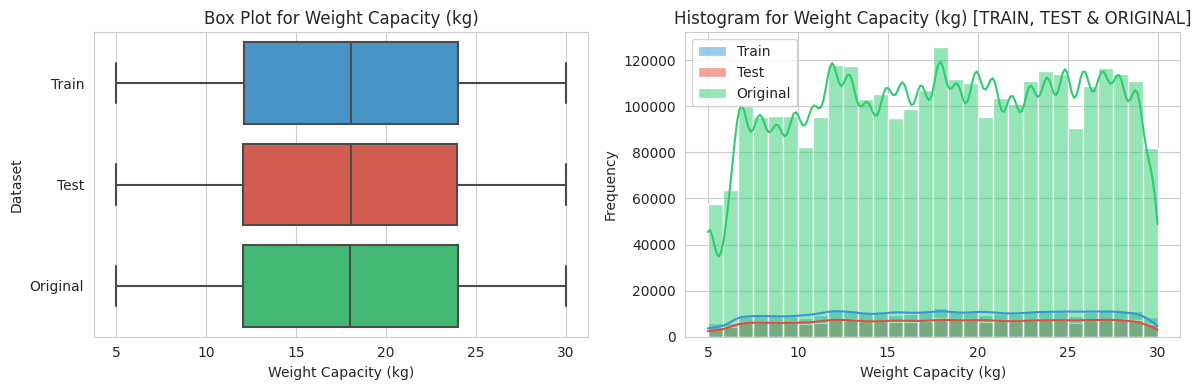

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Analysis of all NUMERICAL features

# Define a custom color palette
custom_palette = ['#3498db', '#e74c3c','#2ecc71']

# Add 'Dataset' column to distinguish between train and test data
train['Dataset'] = 'Train'
test['Dataset'] = 'Test'
extra['Dataset'] = 'Original'

variables = [col for col in train.columns if col in numerical_variables]

# Function to create and display a row of plots for a single variable
def create_variable_plots(variable):
    sns.set_style('whitegrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=pd.concat([train, test, extra.dropna()]), x=variable, y="Dataset", palette=custom_palette)
    plt.xlabel(variable)
    plt.title(f"Box Plot for {variable}")

    # Separate Histograms
    plt.subplot(1, 2, 2)
    sns.histplot(data=train, x=variable, color=custom_palette[0], kde=True, bins=30, label="Train")
    sns.histplot(data=test, x=variable, color=custom_palette[1], kde=True, bins=30, label="Test")
    sns.histplot(data=extra.dropna(), x=variable, color=custom_palette[2], kde=True, bins=30, label="Original")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {variable} [TRAIN, TEST & ORIGINAL]")
    plt.legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Perform univariate analysis for each variable
for variable in variables:
    create_variable_plots(variable)

# Drop the 'Dataset' column after analysis
train.drop('Dataset', axis=1, inplace=True)
test.drop('Dataset', axis=1, inplace=True)
extra.drop('Dataset', axis=1, inplace=True)

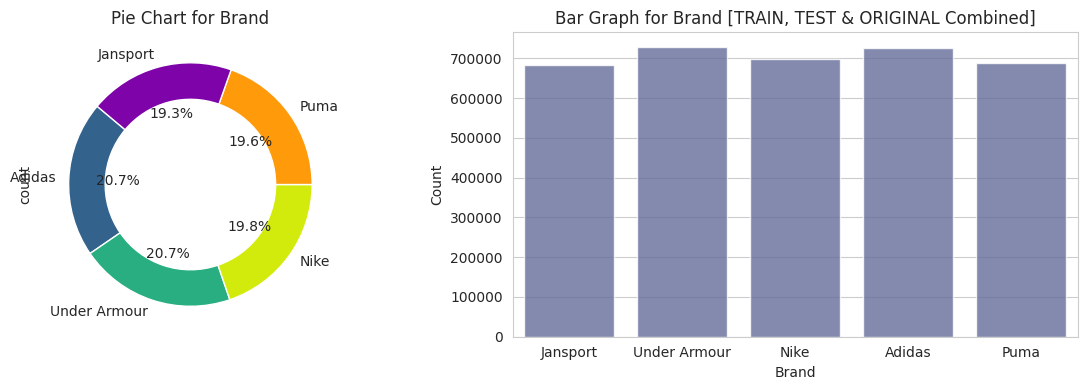

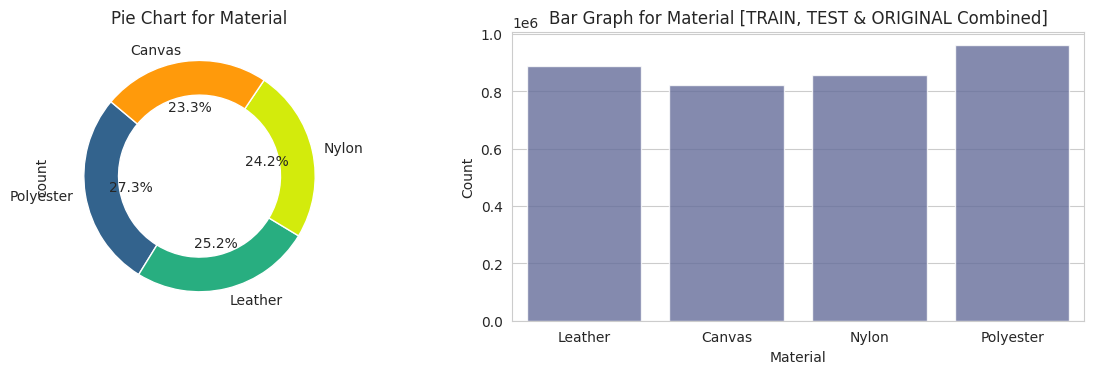

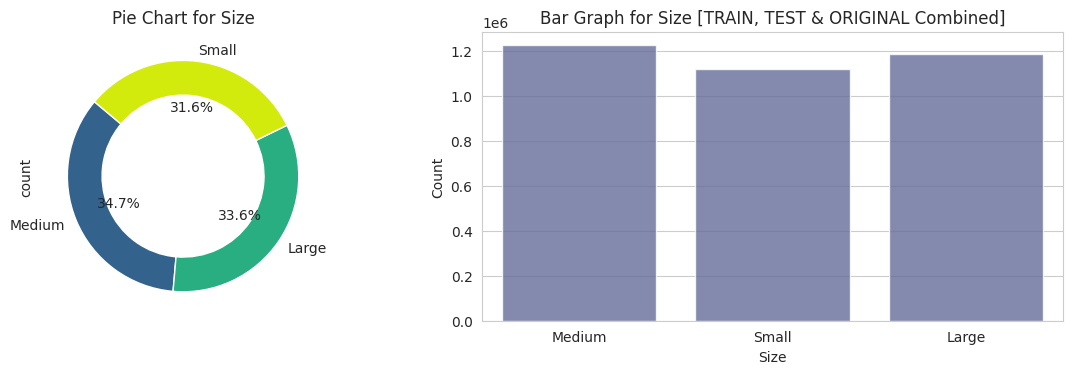

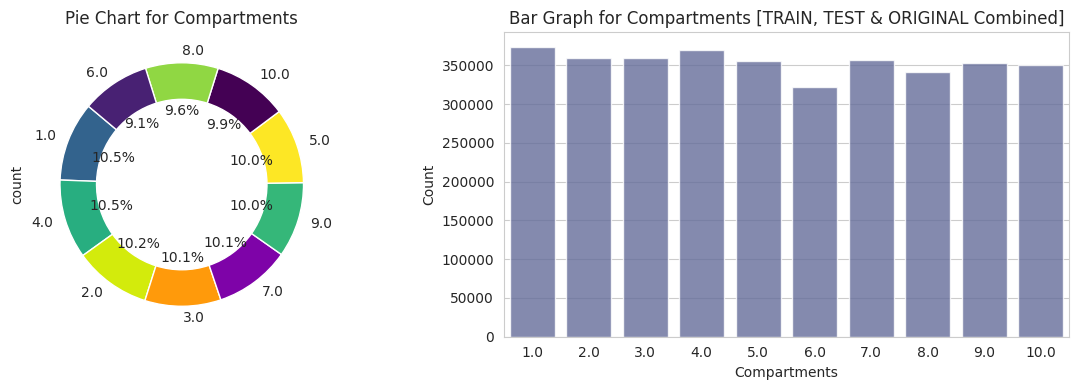

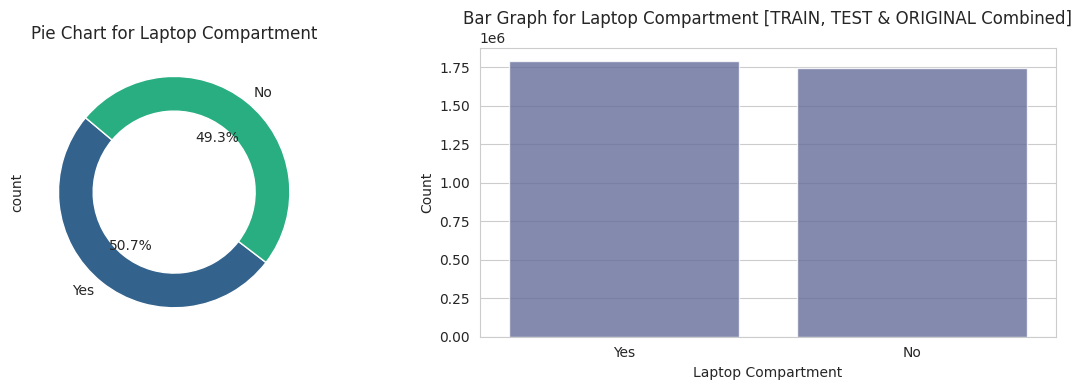

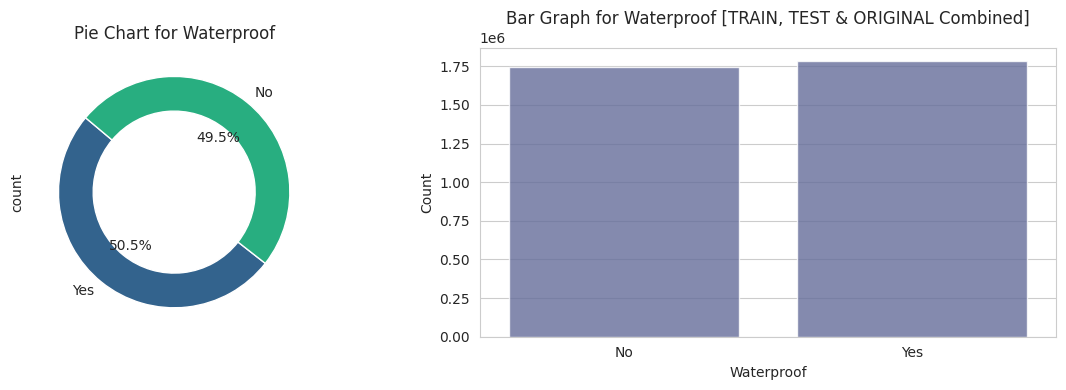

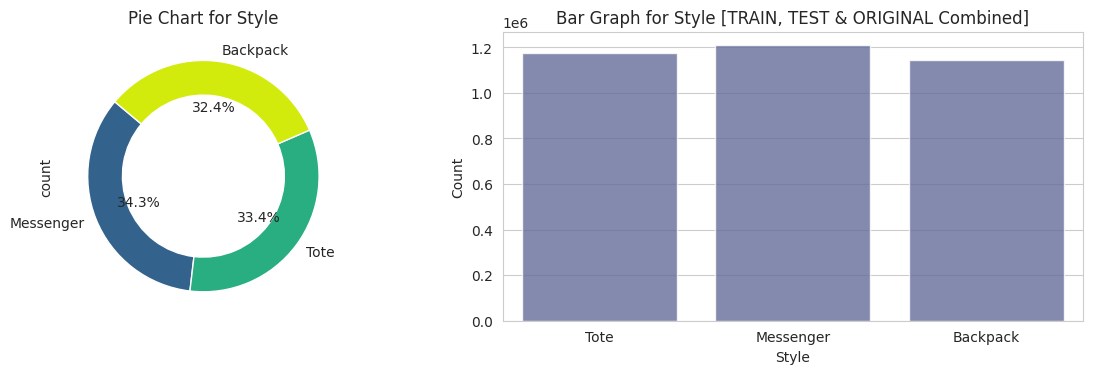

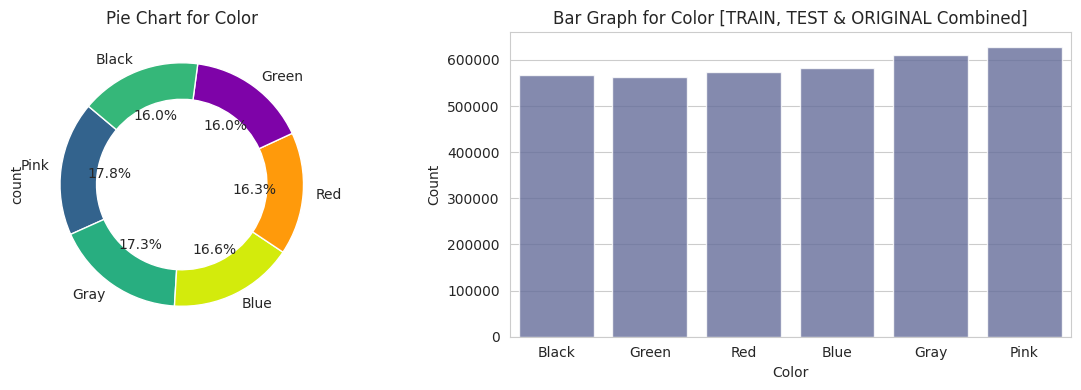

In [10]:
pie_chart_palette = ['#33638d', '#28ae80', '#d3eb0c', '#ff9a0b', '#7e03a8', '#35b779', '#fde725', '#440154', '#90d743', '#482173', '#22a884', '#f8961e']

countplot_color = '#5C67A3'

def create_categorical_plots(variable):
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    plt.subplot(1,2,1)
    train[variable].value_counts().plot.pie(
        autopct="%1.1f%%", colors=pie_chart_palette, wedgeprops=dict(width=0.3), startangle=140 
    )
    plt.title(f"Pie Chart for {variable}")
    
    plt.subplot(1,2,2)
    sns.countplot(
        data=pd.concat([train, test, extra.dropna()]),
        x=variable,
        color=countplot_color,
        alpha=0.8
    )
    plt.xlabel(variable)
    plt.ylabel("Count")
    plt.title(f"Bar Graph for {variable} [TRAIN, TEST & ORIGINAL Combined]")
    
    plt.tight_layout()
    
    plt.show()
    
for variable in categorical_variables:
    create_categorical_plots(variable)

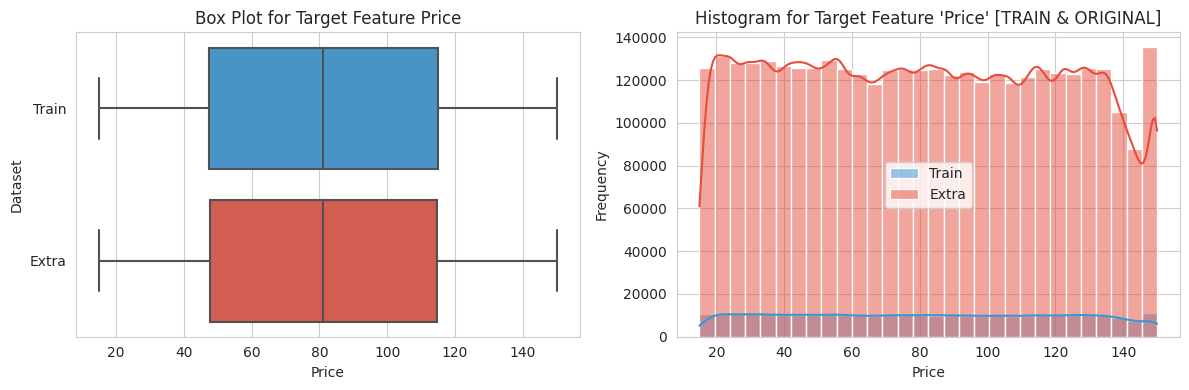

In [11]:
# Define a custom color palette
target_palette = ['#3498db', '#e74c3c']

# Add 'Dataset' column to distinguish between Train and Original data
train['Dataset'] = 'Train'
extra['Dataset'] = 'Extra'

def create_target_plots(variable):
  sns.set_style("whitegrid")
  
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  
  plt.subplot(1,2,1)
  sns.boxplot(data=pd.concat([train, extra.dropna()]), x=target_variable, y="Dataset", palette=target_palette)
  plt.xlabel(target_variable)
  plt.title(f"Box Plot for Target Feature {target_variable}")
  
  plt.subplot(1, 2, 2)
  sns.histplot(data=train, x=target_variable, color=target_palette[0], kde=True, bins=30, label="Train")
  sns.histplot(data=extra, x=target_variable, color=target_palette[1], kde=True, bins=30, label="Extra")
  plt.xlabel(target_variable)
  plt.ylabel("Frequency")
  plt.title(f"Histogram for Target Feature '{target_variable}' [TRAIN & ORIGINAL]")
  plt.legend()
  
  # Adjust spacing between subplots
  plt.tight_layout()
  
  plt.show()

# Perform univariate analysis for the target variable
create_target_plots(target_variable)

train.drop("Dataset", axis=1, inplace=True)
extra.drop("Dataset", axis=1, inplace=True)  

  

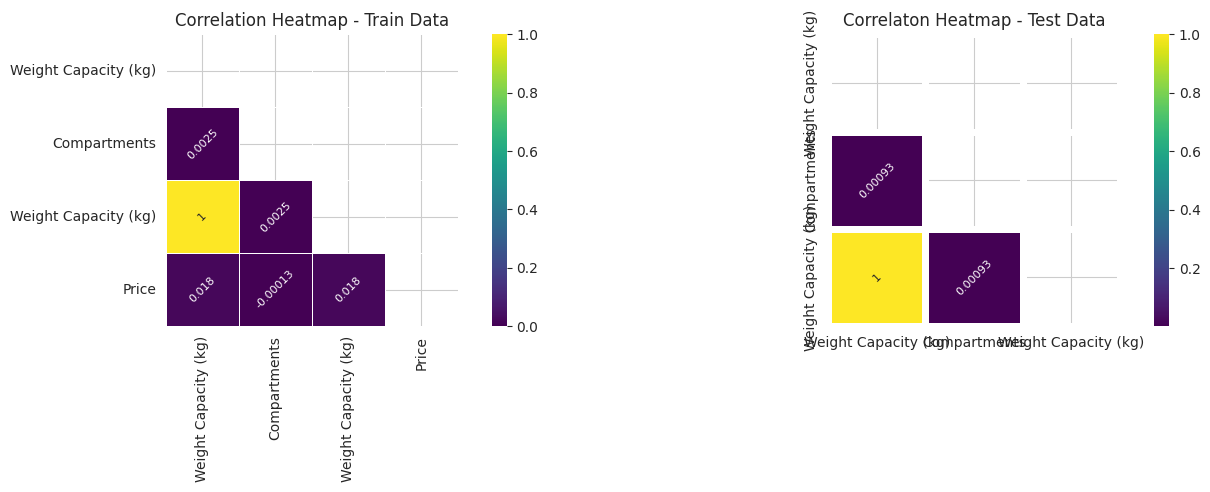

In [12]:
variables = [col for col in train.columns if col in numerical_variables]

cat_variables_train = ["Compartments", "Weight Capacity (kg)", "Price"]
cat_variables_test = ["Compartments", "Weight Capacity (kg)"]

# Adding variables to the existing list
train_variables = variables + cat_variables_train
test_variables = variables + cat_variables_test

# Calculate correlation matrices (相関行列) for train and test
corr_train = train[train_variables].corr()
corr_test = test[test_variables].corr()

# Create masks for the upper triangle
mask_train = np.triu(np.ones_like(corr_train, dtype=bool))
mask_test = np.triu(np.ones_like(corr_test, dtype=bool))

# Set the text size and rotation
annot_kws = {"size": 8, "rotation": 45}

# Generate heatmaps for train
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ax_train = sns.heatmap(corr_train, mask=mask_train, cmap="viridis", annot=True,
                       square=True, linewidth=.5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title("Correlation Heatmap - Train Data")

# Generate heatmaps for test
plt.subplot(1,2,2)
ax_test = sns.heatmap(corr_test, mask=mask_test, cmap="viridis", annot=True,
                      square=True, linewidths=5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title("Correlaton Heatmap - Test Data")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [13]:
# Drop null values from extra
extra = extra.dropna()

# Print the count of null values in extra
print(extra.isnull().sum())

# Combine extra with train
train = pd.concat([train, extra], axis=0).reset_index(drop=True)

id                      0
Brand                   0
Material                0
Size                    0
Compartments            0
Laptop Compartment      0
Waterproof              0
Style                   0
Color                   0
Weight Capacity (kg)    0
Price                   0
dtype: int64


In [14]:
# Define imputation strategies
categorical_features = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]
numerical_features = ["Weight Capacity (kg)"]

# Fill categorical missing values with mode (most frequent value)
for col in categorical_features:
  train[col].fillna(train[col].mode()[0], inplace=True)
  test[col].fillna(test[col].mode()[0], inplace=True)

# Fill numerical missing values with median
for col in numerical_features:
  train[col].fillna(train[col].median(), inplace=True)
  test[col].fillna(test[col].median(), inplace=True)


In [15]:
from sklearn.preprocessing import LabelEncoder

def perform_feature_engineering(df):
    # Brand Material Interaction - Certain materials may be common for specific brands
    df['Brand_Material'] = df['Brand'] + '_' + df['Material']

    # Brand & Size Interaction - Some brands may produce only specific sizes
    df['Brand_Size'] = df['Brand'] + '_' + df['Size']

    # Has Laptop Compartment - Convert Yes/No to 1/0 for easier analysis
    df['Has_Laptop_Compartment'] = df['Laptop Compartment'].map({'Yes': 1, 'No': 0})

    # Is Waterproof - Convert Yes/No to 1/0 for easier analysis
    df['Is_Waterproof'] = df['Waterproof'].map({'Yes': 1, 'No': 0})

    # Compartments Binning - Group compartments into categories
    df['Compartments_Category'] = pd.cut(df['Compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])

    # Weight Capacity Ratio - Normalize weight capacity using the max value
    df['Weight_Capacity_Ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

    # Interaction Feature: Weight vs. Compartments - Some bags may hold more with less compartments
    df['Weight_to_Compartments'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)  # Avoid division by zero

    # Style and Size Interaction - Certain styles may correlate with sizes
    df['Style_Size'] = df['Style'] + '_' + df['Size']

    return df

# Apply the function to the training data
train_data = perform_feature_engineering(train)

# Apply the function to the test data
test_data = perform_feature_engineering(test)

In [16]:
id_test = test_data["id"]

columns_to_drop = ["id"]
train.drop(columns_to_drop, axis=1, inplace=True)
test.drop(columns=columns_to_drop, axis=1, inplace=True)

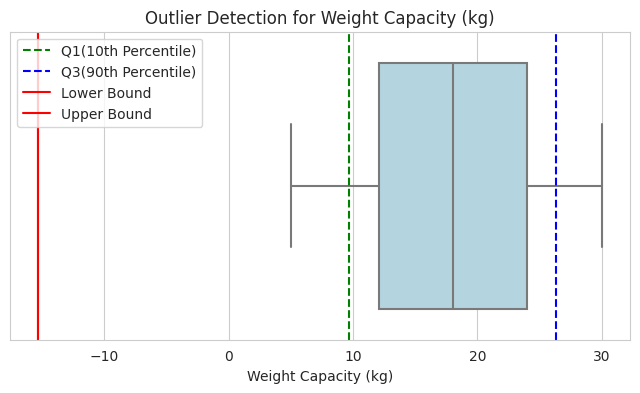

Rows deleted for Weight Capacity (kg): 0


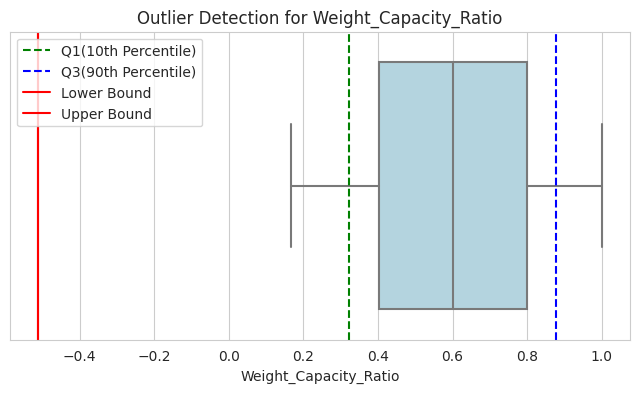

Rows deleted for Weight_Capacity_Ratio: 0


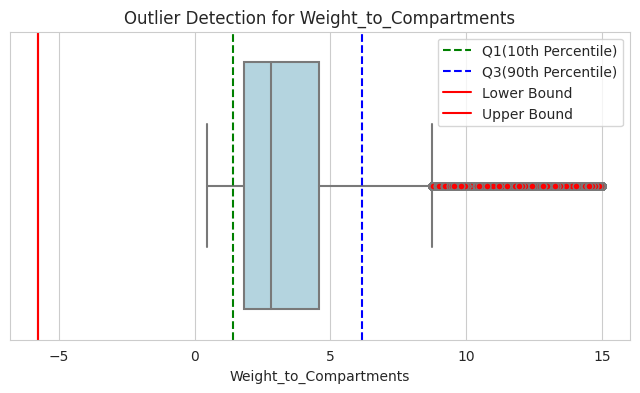

Rows deleted for Weight_to_Compartments: 48176
Total rows deleted: 48176


In [17]:
columns_to_check = ['Weight Capacity (kg)','Weight_Capacity_Ratio','Weight_to_Compartments']

# Function to remove outliers using IQR(Interquartile Range) and visualize
def remove_outliers_iqr_with_plot(data, column):
  Q1 = data[column].quantile(0.15)
  Q3 = data[column].quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  
  # Filter the data
  filtered_data = data[(data[column] >= lower_bound ) & (data[column] <= upper_bound)]
  
  # Calculate the number of rows deleted
  rows_deleted = len(data) - len(filtered_data)
  
  # Plot the distribution with outliers
  plt.figure(figsize=(8, 4))
  sns.boxplot(x=data[column], color="lightblue", flierprops={"marker": "o", "markersize": 5, "markerfacecolor": "red"})
  
  # Highlight Q1 and Q3
  plt.axvline(Q1, color="green", linestyle="--", label="Q1(10th Percentile)")
  plt.axvline(Q3, color="blue", linestyle="--", label="Q3(90th Percentile)")
  
  # Highlight lower and upper bounds
  plt.axvline(lower_bound, color="red", linestyle="-", label="Lower Bound")
  plt.axvline(lower_bound, color="red", linestyle="-", label="Upper Bound")
  
  plt.title(f"Outlier Detection for {column}")
  plt.legend()
  plt.xlabel(column)
  plt.show()
  
  return filtered_data, rows_deleted

# Apply function to each numerical column and visualize
rows_deleted_total = 0

for column in columns_to_check:
  train, rows_deleted = remove_outliers_iqr_with_plot(train, column)
  rows_deleted_total += rows_deleted
  print(f"Rows deleted for {column}: {rows_deleted}")
  
print(f"Total rows deleted: {rows_deleted_total}")

In [18]:
y = train_data["Price"]

In [19]:
# [ FOR TRAIN ]
#Identify features with skewness greater than 0.75
skewed_features = train[numerical_variables].skew()[train[numerical_variables].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Plot skewed features before transformation
for feature in skewed_features:
  plt.figure(figsize=(8, 4))
  sns.histplot(train[feature], bins=0, kde=True, color="blue")
  plt.title(f"Distribution of {feature} before log transformation")
  plt.show()
  
# Apply log1p transformation to skewed features
train[skewed_features] = np.log1p(train[skewed_features])

# Plot skewed features after transformation
for feature in skewed_features:
  plt.figure(figsize=(8, 4))
  sns.histplot(train[feature], bins=50, kde=True, color="green")
  plt.title(f"Distribution of {feature} after log transformation")
  plt.show()


Features to be transformed (skewness > 0.75):


array([], dtype=object)

In [20]:
# [FOR TEST]
# Identify features with skewness greater than 0.75
skewed_features = test_data[numerical_variables].skew()[test_data[numerical_variables].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Plot skewed features before transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(test_data[feature], bins=50, kde=True, color='blue')
    plt.title(f'Distribution of {feature} before log transformation')
    plt.show()

# Apply log1p transformation to skewed features
test_data[skewed_features] = np.log1p(test_data[skewed_features])

Features to be transformed (skewness > 0.75):


array([], dtype=object)

In [21]:
# Plot skewed features after transformation
for feature in skewed_features:
  plt.figure(figsize=(8, 4))
  sns.histplot(test[feature], bins=50, kde=True, color="green")
  plt.title(f"Distribution of {feature} after log transformation")
  plt.show()

In [22]:
# Selecting specific columns for encoding
columns_to_encode = ['Brand', 'Material', 'Size', 'Laptop Compartment','Waterproof', 'Style', 'Color','Brand_Material', 'Brand_Size', 'Has_Laptop_Compartment','Is_Waterproof', 'Compartments_Category', 'Style_Size']
train_to_encode = train[columns_to_encode]
test_to_encode = test[columns_to_encode]

# Dropping selected columns for scaling
train_to_scale = train.drop(columns_to_encode, axis=1)
test_to_scale = test.drop(columns_to_encode, axis=1)

train_encoded = pd.get_dummies(train_to_encode, columns=columns_to_encode, drop_first=True)
test_encoded = pd.get_dummies(test_to_encode, columns=columns_to_encode, drop_first=True)


In [23]:
train_encoded.head()

,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,Size_Medium,Size_Small,Laptop Compartment_Yes,...,Compartments_Category_Many,Compartments_Category_Very Many,Style_Size_Backpack_Medium,Style_Size_Backpack_Small,Style_Size_Messenger_Large,Style_Size_Messenger_Medium,Style_Size_Messenger_Small,Style_Size_Tote_Large,Style_Size_Tote_Medium,Style_Size_Tote_Small
0,True,False,False,False,True,False,False,True,False,True,...,True,False,False,False,False,False,False,False,True,False
1,True,False,False,False,False,False,False,False,True,True,...,True,False,False,False,False,False,True,False,False,False
2,False,False,False,True,True,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
3,False,True,False,False,False,True,False,False,True,True,...,True,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False


In [24]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Fit the scaler on the training data 
minmax_scaler.fit(train_to_scale.drop(["Price"], axis=1))

# Scale the training data 
scaled_data_train = minmax_scaler.transform(train_to_scale.drop(["Price"], axis=1))
scaled_train_df = pd.DataFrame(scaled_data_train, columns=train_to_scale.drop(["Price"], axis=1).columns)

# Scale the test data using the parameters from the training data
scaled_data_test = minmax_scaler.transform(test_to_scale)
scaled_test_df = pd.DataFrame(scaled_data_test, columns=test_to_scale.columns)

In [25]:
scaled_train_df.head()

,Compartments,Weight Capacity (kg),Weight_Capacity_Ratio,Weight_to_Compartments
0,0.666667,0.264469,0.264469,0.077360
1,1.000000,0.883141,0.883141,0.155752
2,0.111111,0.465750,0.465750,0.395240
3,0.777778,0.317489,0.317489,0.076274
4,0.000000,0.509974,0.509974,0.653391


In [26]:
# Concatenate train datasets
train_combined = pd.concat([train_encoded.reset_index(drop=True), scaled_train_df.reset_index(drop=True)], axis=1)

# Concatenate test datasets
test_combined = pd.concat([test_encoded.reset_index(drop=True), scaled_test_df.reset_index(drop=True)], axis=1)

In [27]:
train_combined.head()

,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,Size_Medium,Size_Small,Laptop Compartment_Yes,...,Style_Size_Messenger_Large,Style_Size_Messenger_Medium,Style_Size_Messenger_Small,Style_Size_Tote_Large,Style_Size_Tote_Medium,Style_Size_Tote_Small,Compartments,Weight Capacity (kg),Weight_Capacity_Ratio,Weight_to_Compartments
0,True,False,False,False,True,False,False,True,False,True,...,False,False,False,False,True,False,0.666667,0.264469,0.264469,0.077360
1,True,False,False,False,False,False,False,False,True,True,...,False,False,True,False,False,False,1.000000,0.883141,0.883141,0.155752
2,False,False,False,True,True,False,False,False,True,True,...,False,False,True,False,False,False,0.111111,0.465750,0.465750,0.395240
3,False,True,False,False,False,True,False,False,True,True,...,False,False,True,False,False,False,0.777778,0.317489,0.317489,0.076274
4,False,False,False,False,False,False,False,True,False,True,...,False,True,False,False,False,False,0.000000,0.509974,0.509974,0.653391


In [28]:
# Define Cross-Validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# CatBoost parameters (optimized)
catboost_params = {
  "iterations": 300,
  "learning_rate": 0.1,
  "depth": 6,
  "verbose": 0,
  "random_seed": 42,
}

# Lists to store results
rmse_scores = []
mae_scores = []
oof_preds = np.zeros(len(train_combined))
test_preds_cb = np.zeros(len(test_combined))

# Store feature importances
feature_importance_list = np.zeros(train_combined.shape[1])

# Perfome K-Fold Cross Validation
print("Training using Cross-Validation")
for fold, (train_idx, val_idx) in enumerate(kf.split(train_combined)):
  print(f"\nTrainng Fold {fold+1}")
  X_train, X_val = train_combined.iloc[train_idx], train_combined.iloc[val_idx]
  y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
  
  # Define model
  cb_model = cb.CatBoostRegressor(**catboost_params)
  
  # Train model
  cb_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
  
  # Predict on validation set
  val_preds_cb = cb_model.predict(X_val)
  oof_preds[val_idx] = val_preds_cb
  
  # Calculate and store scores
  rmse = np.sqrt(mean_squared_error(y_val, val_preds_cb))
  mae = mean_absolute_error(y_val, val_preds_cb)
  rmse_scores.append(rmse)
  mae_scores(mae)
  
  print(f"Fold {fold+1} RMSE: {rmse:.4f}, MAE: {mae:.4f}")
  
  # Accumulate feature importances
  feature_importance_list += cb_model.get_feature_importance() / kf.get_n_splits()
  
  # Predict on test data and average across folds
  test_preds_cb += cb_model.predict(test_combined) / kf.get_n_splits